# Element volume locking

***
***

## General formulation of the problem

---

Let us remind the relationships between $(\lambda,\mu)$ and $(E, \nu)$
\begin{equation}
\lambda=\frac{E\nu}{(1+\nu)(1-2\nu)},\,\,\,\,\mu=\frac{E}{2(1+\nu)}.
\end{equation}

The basic formulation introduced in the 2D problem is based on stiffness,
but for $\nu\rightarrow 0.5$ the Young modulus $E\rightarrow\infty$
and hence the calculation collapses near $\nu=0.5$.
This singularity introduces a so called volume locking,
which can be seen from the following simple numerical experiment.
Let us consider a rectangular domain, fixed on the bottom and loaded on the top edge.
Moreover let us suppose an almost critical value of Poisson ratio $\nu=0.4999$.

The problem is implemented as in *2D_Elasticity* example.
The domain response should be symmetrical; however, the result is...

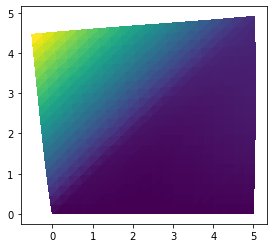

In [13]:
import fenics as fe
import matplotlib.pyplot as plt
import numpy as np


# --------------------
# Functions and classes
# --------------------
def bottom(x, on_boundary):
    return (on_boundary and fe.near(x[1], 0.0))


# Strain function
def epsilon(u):
    return 0.5*(fe.nabla_grad(u) + fe.nabla_grad(u).T)


# Stress function
def sigma(u):
    return lmbda*fe.div(u)*fe.Identity(2) + 2*mu*epsilon(u)


# --------------------
# Parameters
# --------------------
E = 70.0e6  # Youngs modulus
nu = 0.4999  # Poissons ratio
lmbda, mu = E*nu/(1 + nu)/(1 - 2*nu), E/2/(1 + nu)  # Lame's constant

l_x, l_y = 5.0, 5.0  # Domain dimensions
n_x, n_y = 20, 20  # Number of elements

# Load
g_int = -10000000.0

# --------------------
# Geometry
# --------------------
mesh = fe.RectangleMesh(fe.Point(0.0, 0.0), fe.Point(l_x, l_y), n_x, n_y)

# Definition of Neumann condition domain
boundaries = fe.MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
boundaries.set_all(0)

top = fe.AutoSubDomain(lambda x: fe.near(x[1], 5.0))

top.mark(boundaries, 1)
ds = fe.ds(subdomain_data=boundaries)

# --------------------
# Function spaces
# --------------------
V = fe.VectorFunctionSpace(mesh, "CG", 1)
u_tr = fe.TrialFunction(V)
u_test = fe.TestFunction(V)
g = fe.Constant((0.0, g_int))

# --------------------
# Boundary conditions
# --------------------
bc = fe.DirichletBC(V, fe.Constant((0.0, 0.0)), bottom)

# --------------------
# Weak form
# --------------------
a = fe.inner(sigma(u_tr), epsilon(u_test))*fe.dx
l = fe.inner(g, u_test)*ds(1)

# --------------------
# Solver
# --------------------
u = fe.Function(V)
fe.solve(a == l, u, bc)

# --------------------
# Post-process
# --------------------
fe.plot(u, mode="displacement")
plt.show()

To recover the correct physical behavior,
we switch to mixed variational problem formulation.
In the previous example we supposed the stress tensor is
\begin{equation}
    \boldsymbol{\sigma}=\lambda\mathrm{div}(\mathbf{u})\mathbf{I} + 2\mu\boldsymbol{\varepsilon}(\mathbf{u})
\end{equation}
and $\mathbf{u}$ was the unknown field.
Here we define $p=-\lambda\mathrm{div}\mathbf{u}$, the hydrostatic pressure, as an additional unknown.
Hence the previous strong form
\begin{align*}
	\text{div} \boldsymbol{\sigma} + \mathbf{b} &= 0 && \text{in } \Omega, \\
	\boldsymbol{\sigma} \cdot \mathbf{n} &= \mathbf{g} && \text{on } \Gamma_{\text{N}}, \\
	\mathbf{u} &= \bar{\mathbf{u}} && \text{on } \Gamma_{\text{D}},
\end{align*}
is replaced by more equations
\begin{align*}
	- \nabla p + \mathrm{div}(2 \mu \boldsymbol{\varepsilon}(\mathbf{u})) + \mathbf{b} &= 0 && \text{in } \Omega, \\
	\mathrm{div}\mathbf{u} + \frac{p}{\lambda} &= 0 && \text{in } \Omega, \\
	p \mathbf{n} + 2 \mu \boldsymbol{\varepsilon}(\mathbf{u}) \cdot \mathbf{n} &= \mathbf{g} && \text{on } \Gamma_{\text{N}}, \\
	\mathbf{u} &= \bar{\mathbf{u}} && \text{on } \Gamma_{\text{D}},
\end{align*}
Its weak formulation being: find $(\mathbf{u},p)$ s.t. $\mathbf{u} - \bar{\mathbf{u}} \in \mathbf{V}$, $p \in P$ and
\begin{align*}
    -\int_\Omega p \text{ div}\, \delta\mathbf{u} \,\mathrm{d}V
    +
    \int_\Omega 2 \mu \boldsymbol{\varepsilon} : \delta \boldsymbol{\varepsilon} \,\mathrm{d}V
    &= \int_\Omega \mathbf{b} \cdot \delta\mathbf{u} \,\mathrm{d}V
    + \int_{\partial \Omega} \mathbf{g} \cdot \delta\mathbf{u} \,\mathrm{d}S,
    \quad \forall \delta\mathbf{u} \in \mathbf{V}, \\
    \int_\Omega \left(\mathrm{div}\mathbf{u}+\frac{p}{\lambda} \right) q \,\mathrm{d}V
    &=
    0,
    \quad \forall q \in P.
\end{align*}
It is an example of Hellinger-Reissner mixed formulation
and the existence is assured e.g. by the inf-sup or Ladyzhenskaya-Babuška-Brezzi condition
(https://en.wikipedia.org/wiki/Ladyzhenskaya%E2%80%93Babu%C5%A1ka%E2%80%93Brezzi_condition).

## Implementation

---

Since FEniCS requires only one form, we rewrite the system above to a one variational equality
\begin{equation}
    -\int_\Omega p \text{ div}\, \delta\mathbf{u} \,\mathrm{d}V
    +
    \int_\Omega 2 \mu \boldsymbol{\varepsilon} : \delta \boldsymbol{\varepsilon} \,\mathrm{d}V
    - \int_\Omega \left(\mathrm{div}\mathbf{u}+\frac{p}{\lambda} \right) q \,\mathrm{d}V
    = \int_\Omega \mathbf{b} \cdot \delta\mathbf{u} \,\mathrm{d}V
    + \int_{\partial \Omega} \mathbf{g} \cdot \delta\mathbf{u} \,\mathrm{d}S,
    \quad \forall \delta\mathbf{u} \in \mathbf{V},\, \forall q \in P.
\end{equation}
We have to also choose the discrete subspaces carefully in order to keep the Babuška-Brezi condition valid,
even uniformly with respect to the discretization parameter;
see the list of suitable pairs of function spaces in [Hughes, T. J. R. - The Finite Element Method (1987), Chapter 4, pp. 201]

Now we are ready to proceed with the implementation itself.
First of all it is necessary redefine stress function using new variable $p$.

In [14]:
import fenics as fe
import matplotlib.pyplot as plt

# --------------------
# Functions and classes
# --------------------
def bottom(x, on_boundary):
    return (on_boundary and fe.near(x[1], 0.0))


# Strain function
def epsilon(u):
    return fe.sym(fe.grad(u))


# Stress function
def sigma(u, p):
    return p*fe.Identity(2) + 2*mu*epsilon(u)


Definitions of material constants and mesh remain the same.

In [15]:
# --------------------
# Parameters
# --------------------
E = 70.0e6  # Youngs modulus
nu = 0.4999  # Poissons ratio
lmbda, mu = E*nu/(1 + nu)/(1 - 2*nu), E/2/(1 + nu)  # Lame's constant

l_x, l_y = 5.0, 5.0  # Domain dimensions
n_x, n_y = 20, 20  # Number of elements

# Load
g_int = -10000000.0
g = fe.Constant((0.0, g_int))

# --------------------
# Geometry
# --------------------
mesh = fe.RectangleMesh(fe.Point(0.0, 0.0), fe.Point(l_x, l_y), n_x, n_y)

# Definition of Neumann condition domain
boundaries = fe.MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
boundaries.set_all(0)

top = fe.AutoSubDomain(lambda x: fe.near(x[1], l_y))

top.mark(boundaries, 1)
ds = fe.ds(subdomain_data=boundaries)

The crucial aspect of the mixed formulation is the definition of function spaces.
The space for displacements is a vector-valued,
while the pressure variable is a scalar.
In addition, it is necessary to select different degrees of freedom for each variable to keep Babuška–Brezzi inf-sup condition fulfiled.
For implementation of such spaces in FEniCS it is necessary to define individual element objects:

In [16]:
P1 = fe.VectorElement('P', fe.triangle, 2)
P2 = fe.FiniteElement('P', fe.triangle, 1)

where the first stands for a second-order polynomial vector-valued element
and the second for a first-order polynomial scalar element.
The next step is a definition of mixed element by calling the *MixedElement* constructor with an array of an individual elements.

In [17]:
element = fe.MixedElement([P1, P2])

Finally, mixed function space is created by the *FunctionSpace* object with a mixed element as an argument.

In [18]:
V = fe.FunctionSpace(mesh, element)

Dirichlet boundary condition is defined as standard.
In this case the space *V* repsesents the whole mixed function space,
*V.sub(0)* represents the vector-valued displacement subspace and *V.sub(1)* represents the scalar space for pressure.

In [19]:
# --------------------
# Boundary conditions
# --------------------
bc = fe.DirichletBC(V.sub(0), fe.Constant((0.0, 0.0)), bottom)

It is also possible to access the individual subspaces of subspace.
For example *V.sub(0).sub(1)* is a space for displacements in the $y$-axis.

In [20]:
bc_2 = fe.DirichletBC(V.sub(0).sub(1), 0.0, bottom)

*fe.TestFunction(V)* in the mixed formulation returns a test function on defined on the whole mixed space.
It is possible to extract the test functions from individual spaces by the function *fe.split()*,
but a simpler solution is calling *fe.TestFunctions(V)* instead of *fe.TestFunction(V)*;
it returns splitted functions of individual spaces. The same holds for trial functions.

The weak form below is valid for nearly incompressible continuum.
For a full incompressibility, it is neccessary to omit the $p/\lambda$ term.

In [21]:
# --------------------
# Weak form
# --------------------
u_test, p_test = fe.TestFunctions(V)
u_tr, p_tr = fe.TrialFunctions(V)

a = fe.inner(epsilon(u_test), sigma(u_tr, p_tr))*fe.dx
a += -p_test*(fe.div(u_tr) + p_tr/lmbda)*fe.dx
L = fe.inner(g, u_test)*ds(1)

The solution is obtained in the standard way.

In [22]:
# --------------------
# Solver
# --------------------
sol = fe.Function(V)
fe.solve(a == L, sol, bc)

To postprocess the solution, it is sometimes useful to access to subspaces by calling *.sub(n)*.

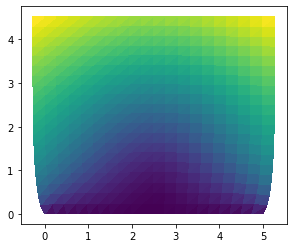

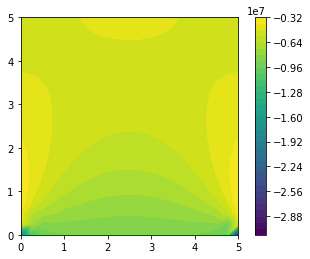

In [23]:
# --------------------
# Post-process
# --------------------
# Plot solution
fe.plot(sol.sub(0), mode="displacement")
plt.show()
plot = fe.plot(sol.sub(1))
plt.colorbar(plot)
plt.show()

### Subspaces

In this example, the solution is saved in *sol* variable as a mixed function.
To acces individual subfunctions, FEniCS provides the function *split*.
There exist two different versions of this function,
the first is called via FEniCS package

In [24]:
u, p = fe.split(sol)

which returns some kind of link on subspace.
Usually it is sufficient e.g. for plotting for example,
but cannot be used for some operations with subfunctions.
FEniCS therefore provides another split function

In [25]:
u, p = sol.split()

which returns two subfunctions of a type *Function*. 

## Complete code

---

Calling FFC just-in-time (JIT) compiler, this may take some time.


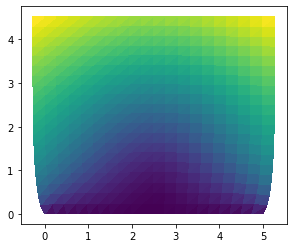

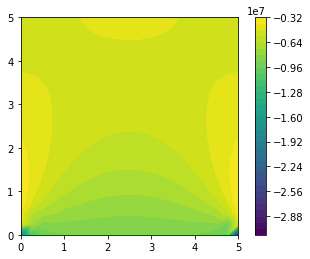

In [26]:
import fenics as fe
import matplotlib.pyplot as plt

# --------------------
# Functions and classes
# --------------------
def bottom(x, on_boundary):
    return (on_boundary and fe.near(x[1], 0.0))


# Strain function
def epsilon(u):
    return 0.5*(fe.nabla_grad(u) + fe.nabla_grad(u).T)


# Stress function
def sigma(u, p):
    return p*fe.Identity(2) + 2*mu*epsilon(u)


# --------------------
# Parameters
# --------------------
E = 70.0e6  # Youngs modulus
nu = 0.4999  # Poissons ratio

l_x, l_y = 5.0, 5.0  # Domain dimensions
n_x, n_y = 20, 20  # Number of elements

# Load
g_int = -10000000.0

# --------------------
# Geometry
# --------------------
mesh = fe.RectangleMesh(fe.Point(0.0, 0.0), fe.Point(l_x, l_y), n_x, n_y)

# Definition of Neumann condition domain
boundaries = fe.MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
boundaries.set_all(0)

top = fe.AutoSubDomain(lambda x: fe.near(x[1], l_y))

top.mark(boundaries, 1)
ds = fe.ds(subdomain_data=boundaries)

# --------------------
# Function spaces
# --------------------
P1 = fe.VectorElement('P', fe.triangle, 2)
P2 = fe.FiniteElement('P', fe.triangle, 1)
element = fe.MixedElement([P1, P2])
V = fe.FunctionSpace(mesh, element)
g = fe.Constant((0.0, g_int))

# --------------------
# Boundary conditions
# --------------------
bc = fe.DirichletBC(V.sub(0), fe.Constant((0.0, 0.0)), bottom)

# --------------------
# Weak form
# --------------------
u_test, p_test = fe.TestFunctions(V)
u_tr, p_tr = fe.TrialFunctions(V)

a = fe.inner(epsilon(u_test), sigma(u_tr, p_tr))*fe.dx
a += -p_test*(fe.div(u_tr) + p_tr/lmbda)*fe.dx
L = fe.inner(g, u_test)*ds(1)


# --------------------
# Solver
# --------------------
sol = fe.Function(V)
fe.solve(a == L, sol, bc)

# --------------------
# Post-process
# --------------------
# Plot solution
fe.plot(sol.sub(0), mode="displacement")
plt.show()
plot = fe.plot(sol.sub(1))
plt.colorbar(plot)
plt.show()

## Uncommented other example - Mindlin beam

---

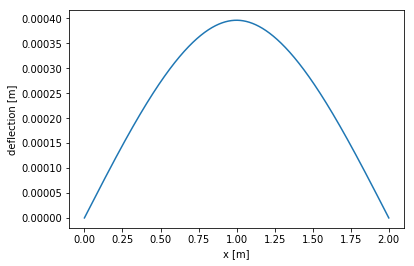

In [42]:
import fenics as fe
import matplotlib.pyplot as plt

# --------------------
# Parameters
# --------------------
E = 50.0e9
G = 25.0e9
b = 0.1
h = 0.01
Ar = b*h
I = (1.0/12.0)*b*h**3

k = 1
f_lin = 1.0
n = 80000
l = 2.0
F = 1.0

# --------------------
# Define geometry
# --------------------
mesh = fe.IntervalMesh(n, 0, l)

# --------------------
# Define spaces
# --------------------
P1 = fe.FiniteElement('P', fe.interval, 2)
element = fe.MixedElement([P1, P1, P1])
V = fe.FunctionSpace(mesh, element)
W = fe.FunctionSpace(mesh, 'P', 2)

d_u, d_w, d_phi = fe.TestFunctions(V)
u, w, phi = fe.TrialFunctions(V)
u_ = fe.Function(V)

# --------------------
# Boundary conditions
# --------------------
bc_u = fe.Constant(0.0)

tol = 1e-14
def left_end(x):
    return fe.near(x[0], 0.0)

def right_end(x):
    return fe.near(x[0], 2.0)

bc1 = fe.DirichletBC(V.sub(0), fe.Constant(0.0), left_end)
bc2 = fe.DirichletBC(V.sub(1), fe.Constant(0.0), left_end)
bc3 = fe.DirichletBC(V.sub(1), fe.Constant(0.0), right_end)
bc4 = fe.DirichletBC(V.sub(0), fe.Constant(0.0), right_end)
bc = [bc1, bc2, bc3, bc4]

# --------------------
# Initialization
# --------------------
X = fe.Function(V)
f = fe.Function(V)
f.interpolate(fe.Constant((0.0, f_lin, 0.0)))

# --------------------
# Solution
# --------------------
dx_shear = fe.dx(metadata={"quadrature_degree": 2})
A = d_u.dx(0)*E*Ar*u.dx(0)*fe.dx + \
    d_w.dx(0)*G*Ar*w.dx(0)*dx_shear + d_w.dx(0)*G*Ar*phi*dx_shear + \
    d_phi.dx(0)*E*I*phi.dx(0)*fe.dx + d_phi*G*Ar*(phi + w.dx(0))*dx_shear + \
    fe.Constant(0.0)*d_w*fe.dx

A_ass, b_ass = fe.assemble_system(fe.lhs(A), fe.rhs(A), bc)

pointForce = fe.PointSource(V.sub(1), fe.Point(1.0), 1)
pointForce.apply(b_ass)

fe.solve(A_ass, X.vector(), b_ass)


u_, w_, phi_ = X.split(deepcopy=True)

#plot(w_)
fe.plot(X.sub(1))
plt.xlabel("x [m]")
plt.ylabel("deflection [m]")
plt.show()